In [1]:
%%HTML
<style>.container { width:99% !important; }</style>

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib  inline

In [3]:
#%% Startup File
startup_file='init_python.py'
exec(open(startup_file).read())

# Shell models dynamics -- How To

## Step 0 : Compilation of the boosted Fortran version and Library importation
It requires f2py:

https://docs.scipy.org/doc/numpy/f2py/

Warnings appear but they are harmless

In [4]:
%%bash
cd Lib_Shells
f2py -c -m Shell4KH_boost Shell4KH_boost.f90 --fcompiler=gnu95 --quiet --f90flags=-O3

In file included from /home/sthalabard/anaconda3/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1822:0,
                 from /home/sthalabard/anaconda3/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/sthalabard/anaconda3/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /tmp/tmpm_jg_sv1/src.linux-x86_64-3.7/fortranobject.h:13,
                 from /tmp/tmpm_jg_sv1/src.linux-x86_64-3.7/Shell4KH_boostmodule.c:16:
/home/sthalabard/anaconda3/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it with " \
  ^~~~~~~
In file included from /home/sthalabard/anaconda3/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1822:0,
                 from /home/sthalabar

In [5]:
from Lib_Shells import Shell4KH_pairs  as shell

FigFolder='./Lib_Shells/Figs'
DataFolder='./Lib_Shells'
if not os.path.exists(FigFolder):os.mkdir(FigFolder)

## Step 1: Creation of a 'flow' instance
The Defining parameters are :

$d$: dimension (d=3 or d=2), that fixes the invariants

$lambda$: InterShell Ratio

$n_{min}$,$n_{max}$ : determines the wave numbers $\Lambda[l]=\lambda_k=\lambda^{k}$ with $k:=k_l = (l+n_{min})$  for $l \in [0,n_{max}-n_{min}]$

$\nu$, $k_{diss}$, $hyper$ : determines the dissipation operator:
$D[u]=-\nu \sum_k\lambda^{2(k-kdiss)hyper} u_k$

$dt$ = Time Steps for Runge Kutta

#### Keys
flow.u : Complex velocity fields 
flow.v 

In [6]:
# Creation d'un flow and time evaluation
# boosted f2py is... 10 times faster!
param={'d':2,\
       'Lambda':2**(1./3),\
       'nu':2e-5,\
       'hyper':1,\
       'nmin':-33,\
       'nmax':41,\
       'dt':2e-4,\
      }

flow=shell.GOY(**param)

# Creation of a ``KH'' initial state (see below)
flow.init_KH(theta=pi/4,a=0.5) #Theta is the phase
flow.t=0
%time flow.integrate_until_boost(tol=10000,Tmax=4);

flow.init_KH(theta=pi/4,a=0.5)
flow.t=0
%time flow.integrate_until(tol=10000,Tmax=4);



CPU times: user 316 ms, sys: 0 ns, total: 316 ms
Wall time: 314 ms
0 0.0 0.0
4.000199999999593 0.0 0.0
CPU times: user 2.93 s, sys: 126 ms, total: 3.06 s
Wall time: 2.86 s


## Step 2: Example. Time evolution of a GOY dynamics with KH initial state

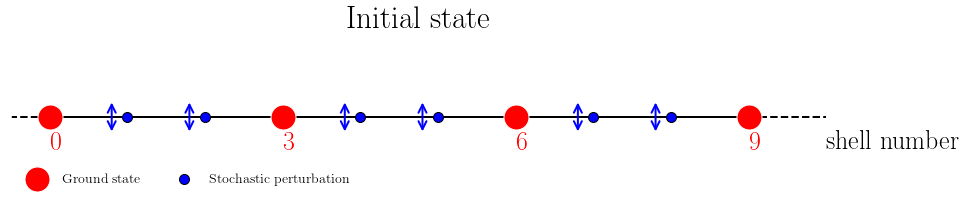

In [7]:
fig,axs=newfig(1,1,figheight=14,aspectratio=0.25,num='Sketch')
ax=axs
for spine in ax.spines.values():spine.set_edgecolor('white')

x=np.array([0,1,2,3,4,5,6,7,8,9])
ax.plot(x,0*x,'k-',linewidth=2)

x=np.array([9,10])
ax.plot(x,0*x,'k--',linewidth=2)

x=np.array([-1,0])
ax.plot(x,0*x,'k--',linewidth=2)

x=np.array([0,3,6,9])
ax.plot(x,0*x,'ro',linewidth=2,markeredgecolor='w',markersize=25,label='Ground state')

x=np.array([1,2,4,5,7,8])
ax.plot(x,0*x,'bo',linewidth=2,markeredgecolor='k',markersize=10,label='Stochastic perturbation')


for i in [1,2,4,5,7,8]:
    ax.annotate( '',xy=(i-0.2,-0.02), xytext=(i-0.2,0.02) ,
            arrowprops=dict(arrowstyle="<->",linewidth=2, mutation_scale=20,color='b'),\
            color='b',annotation_clip=False)
for i in [0,3,6,9]:
    ax.annotate( '$%d$' %(i,), xy=(i,-0.04) ,
            color='r',annotation_clip=False)

ax.annotate( 'shell number', xy=(10,-0.04) ,
            color='k',annotation_clip=False)


ax.legend(ncol=2,loc=3)
    
ax.set_title('Initial state ')
ax.set_xlim(-0.5,10)
ax.set_ylim(-0.1,0.1)
ax.set_yticks([])
ax.set_xticks([])

fig.tight_layout()
fig.savefig(os.path.join(FigFolder,'Shell_SketchInitial.pdf'))

In [8]:
## A function that shows the spectra
def show(flow=None,axs=None,a=0.66,**kwargs):
 
    Ek_u=np.abs(flow.u)**2
    Ek_v=np.abs(flow.v)**2
    Ek_pert=0.5*np.abs(flow.v-flow.u)**2

    Epar=Ek_u[flow.k%3==1]+Ek_u[flow.k%3==2]
    Eg=(Ek_u[:-2:3]+Ek_u[1:-1:3]+Ek_u[2::3])
#    Eg=Ek_u[flow.k%3==0]

    #    Ep=Ek_pert
    Ep=(Ek_pert[:-2:3]+Ek_pert[1:-1:3]+Ek_pert[2::3])
    
    ix=flow.k%3==0

    lams=flow.Lambdas
    ax=axs[0]
    ax.plot(lams[ix],lams[ix]**(a)*Eg,'k--')
#    ax.plot(lams[ix],lams[ix]**(a)*Ep,'-',**kwargs)

    ax=axs[1]
    ax.plot(lams[ix],lams[ix]**(a)*Ep,'-',**kwargs)

    ax=axs[2]
    ax.plot(flow.t,Ep.sum(),'o',markersize=20,**kwargs)

    return None

39 39
CPU times: user 695 µs, sys: 301 µs, total: 996 µs
Wall time: 932 µs
39 39
CPU times: user 1.32 ms, sys: 0 ns, total: 1.32 ms
Wall time: 1.22 ms
78 78
CPU times: user 1.37 ms, sys: 591 µs, total: 1.96 ms
Wall time: 1.91 ms
156 156
CPU times: user 3.3 ms, sys: 0 ns, total: 3.3 ms
Wall time: 3.25 ms
312 312
CPU times: user 6.02 ms, sys: 0 ns, total: 6.02 ms
Wall time: 5.98 ms
625 625
CPU times: user 10.8 ms, sys: 0 ns, total: 10.8 ms
Wall time: 10.7 ms
1250 1250
CPU times: user 19.9 ms, sys: 0 ns, total: 19.9 ms
Wall time: 19.9 ms
2500 2500
CPU times: user 39.5 ms, sys: 0 ns, total: 39.5 ms
Wall time: 39.5 ms
5001 5001
CPU times: user 75.2 ms, sys: 0 ns, total: 75.2 ms
Wall time: 75 ms
10000 10000
CPU times: user 188 ms, sys: 2.62 ms, total: 191 ms
Wall time: 190 ms
20000 20000
CPU times: user 332 ms, sys: 0 ns, total: 332 ms
Wall time: 331 ms
40000 40000
CPU times: user 718 ms, sys: 3.25 ms, total: 722 ms
Wall time: 719 ms
80000 80000
CPU times: user 1.33 s, sys: 0 ns, total: 1.33

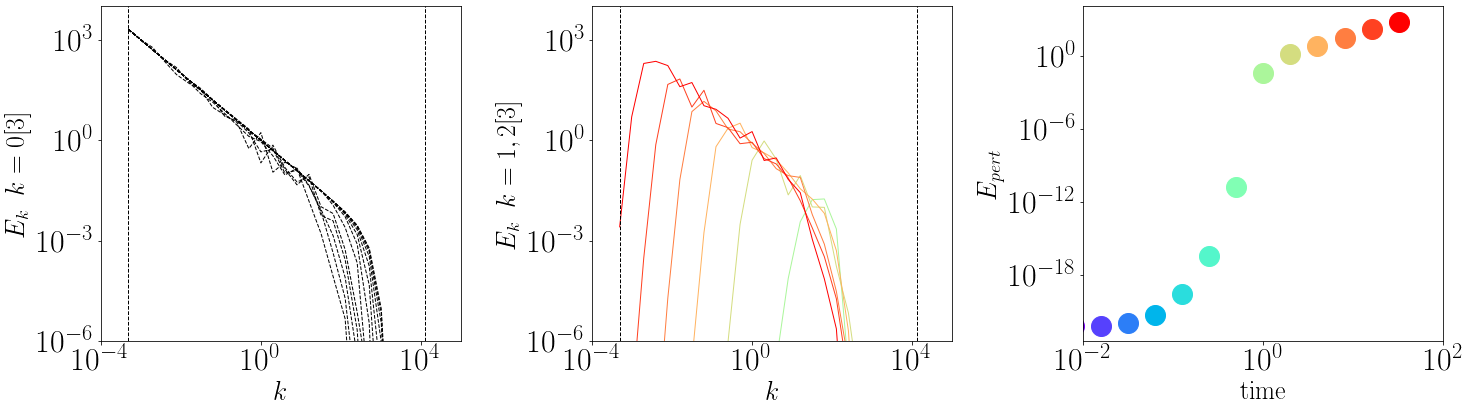

In [9]:
## Creation of a flow
param={'d':2,\
       'Lambda':2**(1./3),\
       'nu':2e-5,\
       'hyper':1,\
       'nmin':-33,\
       'nmax':41,\
       'dt':2e-4,\
      }

flow=shell.GOY(**param)

# Initialization
flow.init_KH(theta=pi/4,a=0.5) #Theta is the phase
flow.perturb(kappa=1e-17,a=2) 
flow.regularize(kmax=36,tol=1e-30)
tstar=flow.t
flow.t=0

fig,axs=newfig(1,3,num='init')
Tmaxs=2**(1.*np.arange(-7,6))
NTmaxs=len(Tmaxs)
colors=cm.rainbow(np.linspace(0,1,NTmaxs))

#Evolution
for i in range(NTmaxs):
    Tmax=Tmaxs[i]
    %time flow.integrate_until_boost(tol=10000,Tmax=Tmax,verbose=True);
    show(flow,axs=axs,color=colors[i],a=0)


for i in [0,1]:
    ax=axs[i]
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.axvline(flow.Lambdas[-1],color='k',linestyle='dashed')
    ax.axvline(flow.Lambdas[0],color='k',linestyle='dashed')
    ax.set_xlim(1e-4,1e5)
    ax.set_ylim(1e-6,1e4)
    ax.set_xlabel('$k$')
    if i==0:
        ax.set_ylabel('$E_k \;\; k=0[3]$')
    if i==1:
        ax.set_ylabel('$E_k  \;\;k=1,2[3]$')
    
ax=axs[2]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-2,1e2)
ax.set_xlabel('time')
ax.set_ylabel('$E_{pert}$')

fig.tight_layout()
